<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#SARIMA" data-toc-modified-id="SARIMA-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>SARIMA</a></span></li><li><span><a href="#Подготовим-выборки" data-toc-modified-id="Подготовим-выборки-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Подготовим выборки</a></span></li><li><span><a href="#SARIMAX" data-toc-modified-id="SARIMAX-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>SARIMAX</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
!pip install pmdarima

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from tqdm import tqdm
import os
import pmdarima as pm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from scipy.stats import boxcox
from scipy.special import inv_boxcox

from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import GridSearchCV,cross_validate,KFold,train_test_split,TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

from catboost import CatBoostRegressor

In [3]:
pth1 = 'taxi.csv'
pth2 = '/datasets/taxi.csv'

if os.path.exists(pth1):
    df = pd.read_csv('taxi.csv',parse_dates=['datetime'])
elif os.path.exists(pth2):
    df = pd.read_csv('/datasets/taxi.csv',parse_dates=['datetime'])
else:
    print('Something is wrong')

**Изучим данные**

In [4]:
df.shape

(26496, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [6]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [7]:
df = df.set_index('datetime')

In [8]:
df.index.min(),df.index.max()

(Timestamp('2018-03-01 00:00:00'), Timestamp('2018-08-31 23:50:00'))

In [9]:
df.resample('1d').sum().shape

(184, 1)

**Ресемплирование данных**

In [10]:
df = df.resample('1H').sum() 

In [11]:
df.shape

(4416, 1)

<div style="border: 3px solid blue; border-radius: 5px; padding: 10px;">
    
Вывод:
    
Данные были загружены, изучены и ресемплированы до одного часа.
    
Представлены данные за 184 дня. Будем использовать почасовые данные (4416)
    

## Анализ

In [12]:
def plot_info(df, column, bins= 10,figsize = (15,7)):
    describe = df[column].describe()
    print(describe)
    print(f'Коэффицент вариации: V =  {(describe["std"]/describe["mean"])}')
    plt.figure(figsize=figsize)
    plt.subplot(2, 1, 1)  
    sns.boxplot(data=df[column], orient='h')
    plt.title('Boxplot')
    plt.xlabel('number of orders');
    plt.subplot(2, 1, 2)  
    sns.histplot(data=df[column],kde=True, bins=bins, color='blue', alpha=0.7)
    plt.title('Histogram')
    plt.xlabel('number of orders');
    plt.tight_layout()
    plt.show()

In [58]:
window_size = 24
trend = df.rolling(window_size).mean()
fig = px.line( title=f'График временного ряда и скользящее среднее с окном {window_size}')
fig.add_scatter(x=df.index, y=df['num_orders'], mode='lines', name='Time Series', line=dict(color='blue'))
fig.add_scatter(x=df.index,y=trend['num_orders'], mode='lines', name='Trend', line=dict(color='red'))
fig.update_xaxes(title_text='Дата')
fig.update_yaxes(title_text='Количество заказов')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

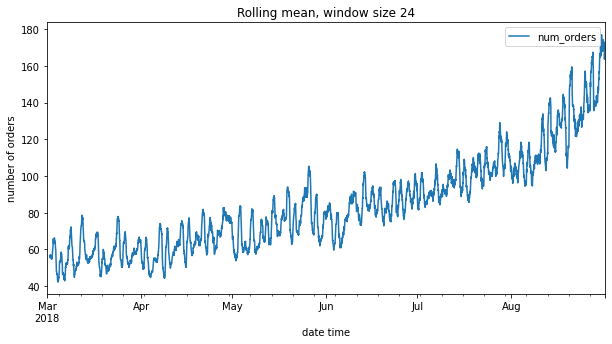

In [14]:
window_size = 24
plt.figure(figsize=(10, 5))
plt.subplot(1,1,1)
df.rolling(window_size).mean().plot(ax=plt.gca())
plt.title(f'Rolling mean, window size {window_size}')
plt.xlabel('date time')
plt.ylabel('number of orders');

Видим, что скользящее среднее растет. Это говорит о нестационарности ряда

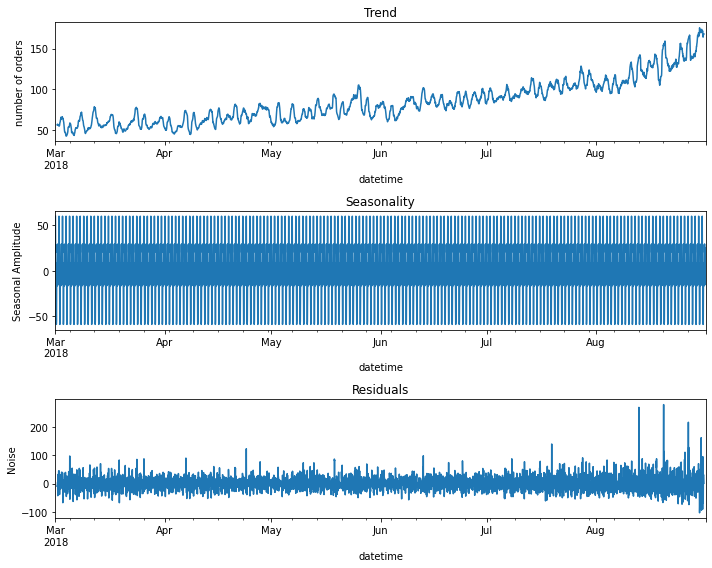

In [15]:
decomposed = seasonal_decompose(df)
plt.figure(figsize=(10, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.ylabel('number of orders');
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.ylabel('Seasonal Amplitude');
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.ylabel('Noise');
plt.tight_layout()

Видно, что тренд возрастает, а так же присутствует сезонность

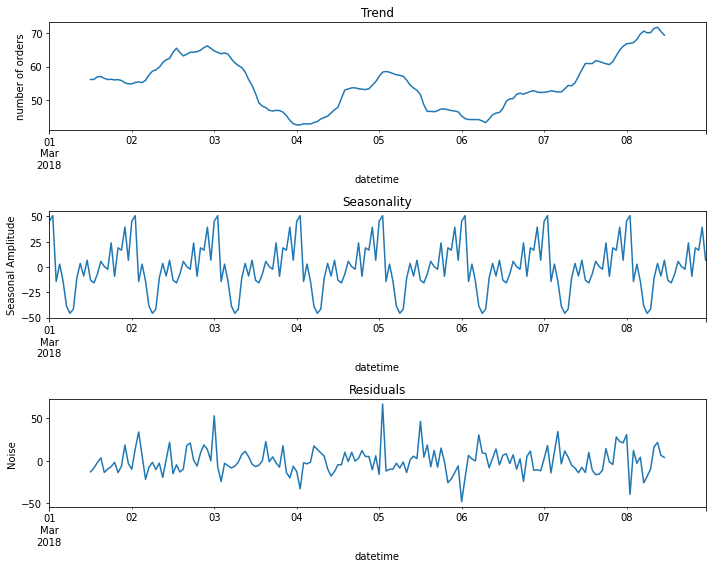

In [16]:
decomposed_week = seasonal_decompose(df['2018-03-01':'2018-03-08'])
plt.figure(figsize=(10, 8))
plt.subplot(311)
decomposed_week.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.ylabel('number of orders');
plt.subplot(312)
decomposed_week.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.ylabel('Seasonal Amplitude');
plt.subplot(313)
decomposed_week.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.ylabel('Noise');
plt.tight_layout()

Присутсвтует дневная сезонность (~24ч)

Посмотрим на колебания внутри одного дня

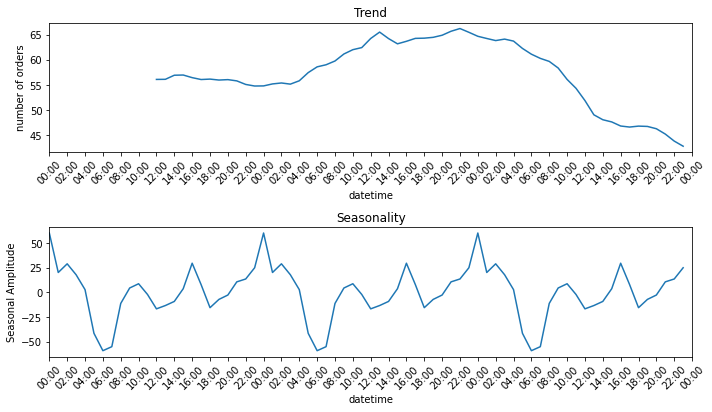

In [17]:
decomposed_week = seasonal_decompose(df)
date_rng = pd.date_range(start='2018-03-01', end='2018-03-04', freq='2H')
hour_labels = [hour.strftime('%H:%M') for hour in date_rng]
plt.figure(figsize=(10, 8))
plt.subplot(311)
decomposed_week.trend['2018-03-01':'2018-03-03'].plot()
plt.xticks(date_rng, hour_labels, rotation=45)
plt.title('Trend')
plt.ylabel('number of orders');
plt.subplot(312)
decomposed_week.seasonal['2018-03-01':'2018-03-03'].plot(ax=plt.gca())
plt.xticks(date_rng, hour_labels, rotation=45)
plt.title('Seasonality')
plt.ylabel('Seasonal Amplitude');
plt.tight_layout()

Видна наибольшая активность заказов такси в 00:00. Так же есть пики в 9:00 и 16:00.

Наименьшая активность в 6:00

Так как данные предоставлены о заказах такси в аэропортах, можно предположить, что это связано с расписанием рейсов. То есть самые востребованые рейсы происходят в вечернее время, то есть самолет прилетает ближе к 00:00. Людям предпочтительнеее такой вариант, тк как они не пропускают работу, учебу или другие дела. 

Похожая ситуация с другими пиками. Например, 6:00 люди прилетают реже, тк для таких рейсов вылет был бы ночью.

count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64
Коэффицент вариации: V =  0.5333140296285983


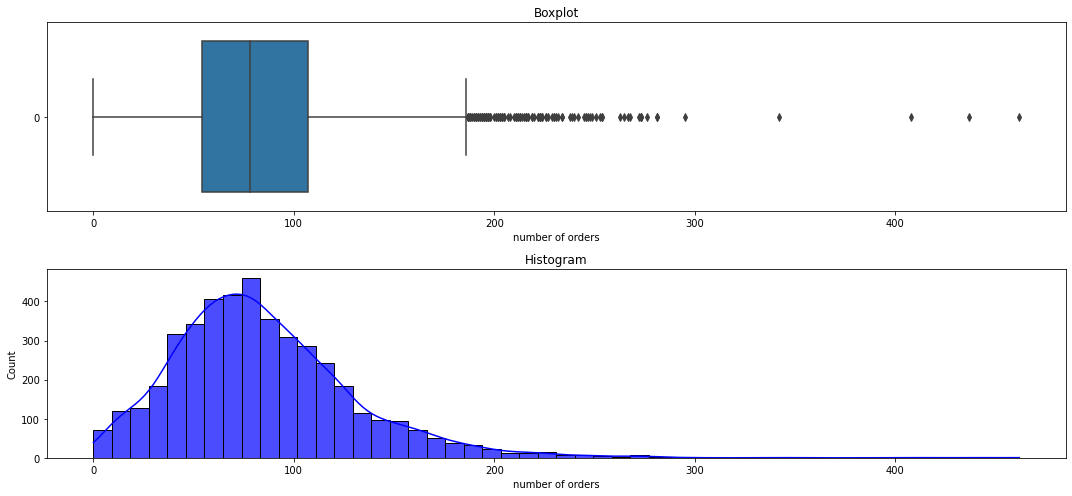

In [18]:
plot_info(df,'num_orders', bins=50)

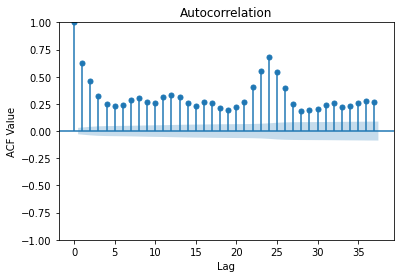

In [19]:
plot_acf(df)
plt.xlabel('Lag')
plt.ylabel('ACF Value')
plt.show()

На графике хорошо видно, что есть автокорреляция с 24 логом, что подтверждает дневнуб сезонность. Так же она находится вне интервала уровня доверия, что говорит о стат значимости автокорреляции.



**тест Дики-Фуллера** (Dickey-Fuller test)
* Нулевая гипотеза предполагает, что ряд нестационарный 
* Альтернативная гипотеза соответственно говорит, что ряд - стационарный 


In [20]:
adf_test = sm.tsa.adfuller(df)
alpha_1 = 0.05
alpha_2 = 0.01
print('p-value = ' + str(adf_test[1]))
if adf_test[1] < alpha_1:
    if adf_test[1] < alpha_2:
        print('Отвергаем нулевую гипотезу. Ряд стационарный')
    else:
        print('5% > p-value > 1%, сложно сказать о стационарности ряда, значение неоднозначное')
else:
    print('Не можем отвергнуть нулевую гипотезу. Нельзя утверждать, что ряд стационарный')

p-value = 0.028940051402612906
5% > p-value > 1%, сложно сказать о стационарности ряда, значение неоднозначное


<div style="border: 3px solid blue; border-radius: 5px; padding: 10px;">
    
Вывод:
    
Было выявлено, что в временной ряд нестационарный. Присутсвует дневная сезонность и возрастающий тренд.
    
p-value по Дики-Фуллера = 0.029 > 1%.
    
В течение одного дня пик заказов приходится на 00:00, а также на 9:00 и 16:00. Наименьшее колво заказов в 6:00.
    
Сезонность заказов связана с расписанием рейсов. Например, в 00:00 пик заказов происходит из-за того, что люди предпочитают вылетать в вечернее время, чтобы не пропускать работу, учебу или другие дела.
    

## Обучение

### Подготовим выборки

In [35]:
def print_all_metrics(true, pred, mode=''):
    rmse = mean_squared_error(true,pred,squared = False)
    mae = mean_absolute_error(true,pred)
    r2 = r2_score(true,pred)

    print()
    print(f'Metrics {mode+":" if mode == "" else " on "+mode +":"}')
    print("----------------------------------------------------------")
    print(f'RMSE _____: {rmse:.4f}')
    print(f'MAE ______: {mae:.4f}')
    print(f'R2 _______: {r2:.4f}')
    print()

In [36]:
metrics = pd.DataFrame(columns=['model','rmse'])

Зададим функцию, которая создаст новые параметры для модели (день, день недели, скользящее среднее, лаги). Год и месяц не используются,тк данные находятся внутри одного года

In [37]:
def make_features(data, col, max_lag, rolling_mean_size, inplace = False):
    if inplace:
        data_copy = data
    else:
        data_copy = data.copy()
    data_copy['day'] = data_copy.index.day
    data_copy['dayofweek'] = data_copy.index.dayofweek
    data_copy['hour'] = data_copy.index.hour
    
    for lag in range(1, max_lag + 1):
        data_copy['lag_{}'.format(lag)] = data_copy[col].shift(lag)

    data_copy['rolling_mean'] = data_copy[col].shift().rolling(rolling_mean_size).mean()
    data_copy = data_copy.dropna()
    return data_copy

In [38]:
df_new_features = make_features(data = df, col = 'num_orders', max_lag = 24, rolling_mean_size = 15)
df_new_features.head()

,num_orders,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,2,4,0,58.0,113.0,66.0,61.0,45.0,73.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,60.533333
2018-03-02 01:00:00,120,2,4,1,90.0,58.0,113.0,66.0,61.0,45.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,61.933333
2018-03-02 02:00:00,75,2,4,2,120.0,90.0,58.0,113.0,66.0,61.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,65.666667
2018-03-02 03:00:00,64,2,4,3,75.0,120.0,90.0,58.0,113.0,66.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,64.266667
2018-03-02 04:00:00,20,2,4,4,64.0,75.0,120.0,90.0,58.0,113.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.533333


In [39]:
train, test = train_test_split(df_new_features, shuffle=False, test_size=0.1)

X_train = train.drop(['num_orders'],axis=1)
y_train = train['num_orders']
X_test = test.drop(['num_orders'],axis=1)
y_test = test['num_orders']

In [40]:
n_folds = 4
cv = TimeSeriesSplit(n_splits=n_folds)

In [41]:
random_seed = 42

### SARIMAX

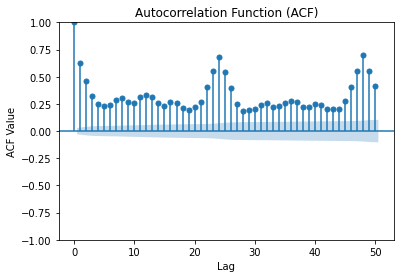

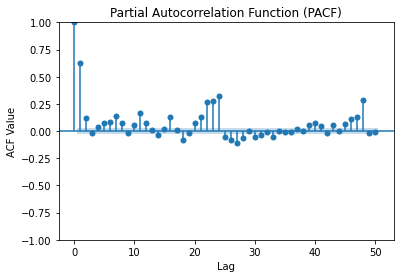

In [42]:
plot_acf(df, lags=50)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('ACF Value')
plt.show()

plot_pacf(df, lags=50, method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('ACF Value')
plt.show()

Параметры сложно определить

подберем автоматически подберем параметры

In [43]:
SARIMA_train, SARIMA_test = train_test_split(df, shuffle=False, test_size=0.1)

In [44]:
# s = 24
# model = pm.auto_arima(SARIMA_train, seasonal=True, m=s, stepwise=True, trace=True)
# print(model.summary())

Наилучшие параметры  SARIMA(5,1,0)(1,0,0)

In [45]:
SARIMA_train, SARIMA_valid = train_test_split(SARIMA_train, shuffle=False, test_size=1/4)

In [46]:
SARIMA_model = SARIMAX(SARIMA_train, order=(5,1,0), seasonal_order=(1,0,0,24), enforce_stationarity=False, enforce_invertibility=False)
results = SARIMA_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.65022D+00    |proj g|=  9.85943D-02


 This problem is unconstrained.



At iterate    5    f=  4.62989D+00    |proj g|=  9.87464D-03

At iterate   10    f=  4.60730D+00    |proj g|=  5.79645D-02

At iterate   15    f=  4.60142D+00    |proj g|=  1.37818D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     17     21      1     0     0   3.116D-06   4.601D+00
  F =   4.6014248080819256     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [47]:
start = SARIMA_train.index[-1]
end = SARIMA_valid.index[-1]
predictions = results.predict(start, end)

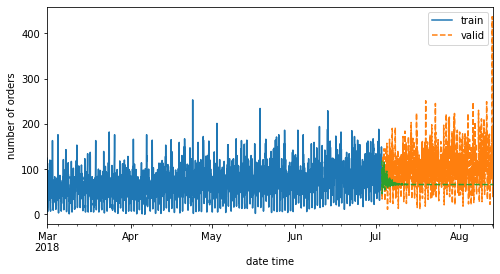

In [59]:
SARIMA_train.plot(label='train')
SARIMA_valid.squeeze().plot(label='valid', figsize=(8,4), style='--')
predictions.squeeze().plot(label='Forecast', figsize=(8,4), style='--')
plt.ylabel('number of orders');
plt.xlabel('date time');
plt.legend(['train', 'valid' ])
plt.show;

модель также работает неадекватно, не будем ее использовать

### LinearRegression

In [49]:
reg_model = LinearRegression()

scores = cross_val_score(reg_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error') 

scores = np.sqrt(-scores)
for i, score in enumerate(scores):
    print(f'Итерация {i+1}: {score}')

print(f'Средняя оценка: {scores.mean()}')
print(f'Стандартное отклонение: {scores.std()}')
metrics.loc[len(metrics)] = ['reg',scores.max()]

Итерация 1: 23.828422420641008
Итерация 2: 25.39602348119757
Итерация 3: 26.81425566828781
Итерация 4: 33.19152073342759
Средняя оценка: 27.307555575888493
Стандартное отклонение: 3.5574820180483235


Видно, что при смещении валидационной выборки (валидационная выборка смещается во времени только вперед, чтобы не было утечки памяти) качество падает. Для сравнения возьмем максимальный

### RandomForestRegressor

In [50]:
forest_params = {
    'random_state':random_seed,
    'n_jobs': -1
}

params = {'max_depth':range(2,10),
          'n_estimators':[50, 100, 150],
         }

grid_search = GridSearchCV(RandomForestRegressor(forest_params), param_grid=params,scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

forest_model = grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = np.sqrt(-grid_search.best_score_)
print("Best Parameters:", best_params)
print("Best RMSE:", best_score)
forest_params.update(best_params)

metrics.loc[len(metrics)] = ['forest',best_score]

Best Parameters: {'max_depth': 9, 'n_estimators': 100}
Best RMSE: 26.468409240622908


### CatBoost

In [51]:
cat_params = {
    'random_state':random_seed,
    'verbose': 0
}

params = {
    'max_depth': range(2,10),
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [50, 100, 200],
}

grid_search = GridSearchCV(estimator=CatBoostRegressor(**cat_params), param_grid=params, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
cat_model = grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = np.sqrt(-grid_search.best_score_)
print("Best Parameters:", best_params)
print("Best RMSE:", best_score)
cat_params.update(best_params)
metrics.loc[len(metrics)] = ['cat',best_score]

Best Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}
Best RMSE: 25.5666849121998


In [52]:
metrics.set_index('model')

,rmse
model,
reg,33.191521
forest,26.468409
cat,25.566685


___

<div style="border: 3px solid blue; border-radius: 5px; padding: 10px;">
    
Вывод:
    
Лучший результат показал CatBoost: rmse = 25.566685

## Тестирование

In [53]:
final_model = CatBoostRegressor(**cat_params)


Metrics :
----------------------------------------------------------
RMSE _____: 43.6634
MAE ______: 32.7754
R2 _______: 0.4454



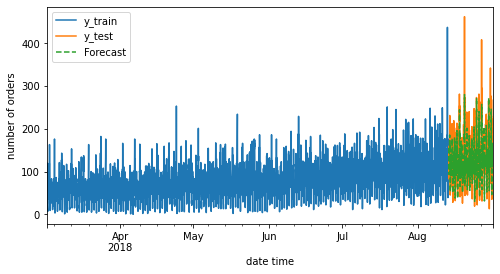

In [54]:
final_model.fit(X_train,y_train)
predict_test = pd.Series(final_model.predict(X_test),index=X_test.index)

print_all_metrics(y_test,predict_test)
y_train.plot(label='y_train')
y_test.plot(label='y_test')
predict_test.plot(label='Forecast', figsize=(8,4), style='--')
plt.ylabel('number of orders');
plt.xlabel('date time');
plt.legend()
plt.show;

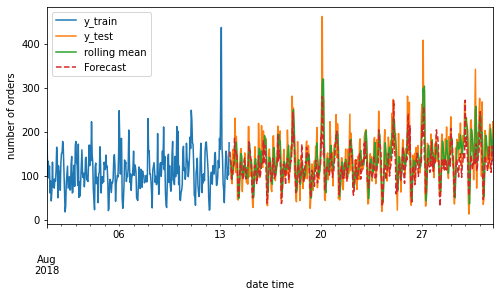

In [55]:
y_train['2018-08'].plot(label='y_train')
y_test['2018-08'].plot(label='y_test')
y_test['2018-08'].rolling(3).mean().plot(label='rolling mean')
predict_test.plot(label='Forecast', figsize=(8,4), style='--')
plt.ylabel('number of orders');
plt.xlabel('date time');
plt.legend()
plt.show;

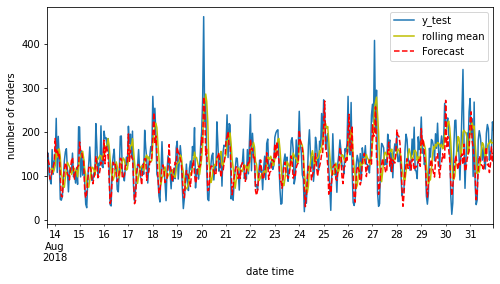

In [56]:
y_test['2018-08'].plot(label='y_test')
y_test['2018-08'].rolling(5).mean().plot(label='rolling mean',color='y')
predict_test.plot(label='Forecast', figsize=(8,4), style='--',color='r')
plt.ylabel('number of orders');
plt.xlabel('date time');
plt.legend()
plt.show;

Видно, что модель не предсказывает выбросы(пики на графике), но хорошо соответствует скользящему среднему

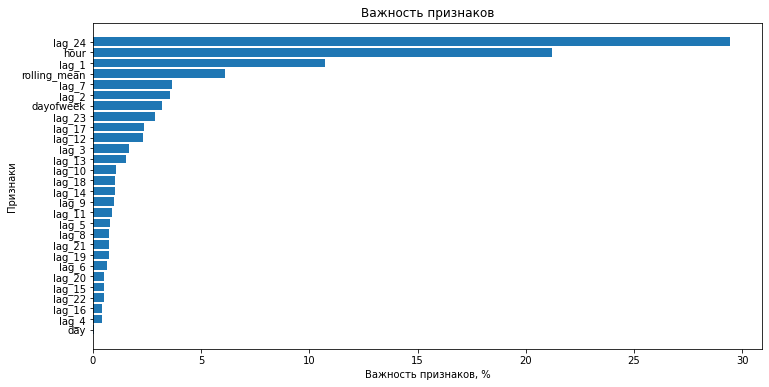

In [57]:
feature_importance = final_model.feature_importances_
feature_names = X_train.columns
feature_importance_dict = dict(zip(feature_names, feature_importance))
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
sorted_feature_names, sorted_feature_values = zip(*sorted_feature_importance)

plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_feature_names)), sorted_feature_values, align='center')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Важность признаков, %')
plt.ylabel('Признаки')
plt.title('Важность признаков')
plt.gca().invert_yaxis()
plt.show()

___

<div style="border: 3px solid blue; border-radius: 5px; padding: 10px;">
    
Вывод:
    
На тестовых данных модель показала rmse = 43.6634
    
Судя по графику модель работает адекватно. Плохо предсказывает пики, но соответствует скользящему среднему
    
Наиболее важные признаки:
    
- lag_24
- hour
- lag_1

- rollling_mean


## Вывод

Было сделано:
- данные были загружены, изучены и ресемплированы по одному часу

- данные были проанализированы: предоставленный временной ряд нестационарный, имеет восходящий тренд и сезонность

- данные были подготовлены к обучению: были добавлены столбцы с месяцем, днем, днем недели, часом, скользящим средним и лагами

- были обучены несколько моделей:
    - линейная регрессия
    - катбус
    - случайный лес
- лучший результат показал случайный лес: rmse = 25.566685
- результат на тестовых данны: rmse = 43.6634

Метрики хоть и проходят по условию задачи, но заметно падают по сравнению с обучающей выборкой. SARIMA должна дать более хороший результат